# RSNA - Create .npy Images

In this notebook, we will apply the selected windows to the DICOM images' pixel arrays, then save the transformed pixel arrays as .npy files. The selected window is bascially a linear transform operation applied on the pixel values. It is determined by a radiologist to make the region of interest (e.g. blood, bone, cavity, etc) most easy to see. It is defined by four values: rescale intercept, rescale slope, window center and window width, which are encoded in the DICOM image file. 

In [1]:
import pandas as pd
import os
import sys

import numpy as np
import pydicom

import matplotlib.pyplot as plt

In [2]:
img_dir = "stage_1_train_images/"

In [3]:
data_table = pd.read_pickle('rsna_data_table.pkl') 
print(len(data_table))

674257


In [4]:
dicom_table = pd.read_pickle('rsna_dicom_table.pkl') 
print(len(dicom_table))

674258


# 1. Look at some of the images with specified window

In [5]:
def apply_window(pixel_data, rescale_slope, rescale_intercept, window_center, window_width):
        
        #apply the window
        pixel_data = pixel_data*rescale_slope + rescale_intercept
        data_min = window_center - window_width//2
        data_max = window_center + window_width//2
        
        pixel_data[pixel_data < data_min] = data_min
        pixel_data[pixel_data > data_max] = data_max
        
        #scale the windowed pixel array to a range of 0 to 255
        pixel_data = (pixel_data - pixel_data.min())/(pixel_data.max()-pixel_data.min())*255
        
        #save as uint8, which is sufficient, to maintain small file size
        return np.uint8(pixel_data)

In [6]:
def plot_images(width, height, data_ids, dicom_table, img_dir):

    fig, axs = plt.subplots(width, height,figsize=(12,12))

    for ind in range(0, width*height):
       
        img_id = data_ids[ind]   
        file_name = os.path.join(img_dir,"ID_"+img_id+".dcm")
        ds = pydicom.dcmread(file_name)
    
        window_width = dicom_table.loc[img_id]['window width']
        window_center = dicom_table.loc[img_id]['window center']
    
        if isinstance(window_width, list):
            window_width = window_width[0]
        
        if isinstance(window_center, list):
            window_center = window_center[0]
        
        rescale_intercept = dicom_table.loc[img_id]['rescale intercept']
        rescale_slope = dicom_table.loc[img_id]['rescale slope']  
    
        img = apply_window(ds.pixel_array, rescale_slope, rescale_intercept, window_center, window_width)
    
        i = ind // width
        j = ind % width
    
        axs[i,j].imshow(img, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        

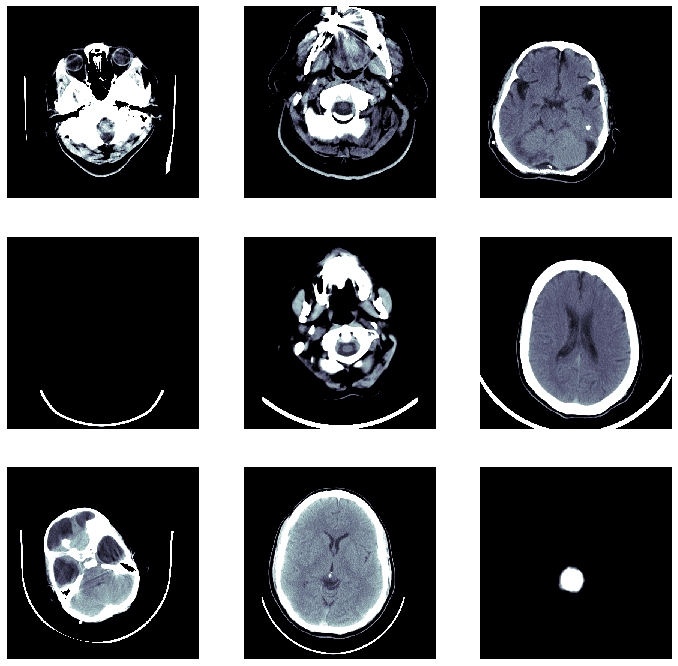

In [7]:
data_ids = pd.Series(data_table.index)
plot_images(3,3, data_ids, dicom_table, img_dir)

# 2. Apply window to images and save as .npy files

In [8]:
npy_dir = "stage_1_train_images_npy/"

In [9]:
def save_image_as_npy(img_id, dicom_table, img_dir, npy_dir):
    
    file_name = os.path.join(img_dir,"ID_"+img_id+".dcm")
    ds = pydicom.dcmread(file_name)
    
    window_width = dicom_table.loc[img_id]['window width']
    window_center = dicom_table.loc[img_id]['window center']
    
    rescale_intercept = dicom_table.loc[img_id]['rescale intercept']
    rescale_slope = dicom_table.loc[img_id]['rescale slope']  
    
    if isinstance(window_width, list):
        window_width = window_width[0]
        
    if isinstance(window_center, list):
        window_center = window_center[0]
       
    img = apply_window(ds.pixel_array, rescale_slope, rescale_intercept, window_center, window_width)
    
    outfile = os.path.join(npy_dir,"ID_"+img_id+".npy")
    np.save(outfile, img)
             
    #I had to remove the original file to save space
    os.remove(file_name)

In [24]:
#data_ids = pd.Series(data_table.index)
#out = data_ids.apply(lambda x: save_image_as_npy(x, dicom_table, img_dir, npy_dir))

imgs = pd.Series(os.listdir(img_dir))

def get_id(x):
    id_parts = x.split('_')
    file_parts = id_parts[1].split('.')
    
    return file_parts[0]
    
imgs = imgs.apply(lambda x: get_id(x))
out = imgs.apply(lambda x: save_image_as_npy(x, dicom_table, img_dir, npy_dir))

In [29]:
img_files = os.listdir(img_dir)
len(img_files)

1

#### Observation: It turns out one of the files could not be converted

In [30]:
npy_files = os.listdir(npy_dir)
len(npy_files)

674257

In [34]:
data_table = data_table.drop(index = get_id(img_files[0]))
len(data_table)

674257

In [35]:
#Save the data table into a file
data_table.to_pickle('rsna_data_table.pkl') 